##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quickstart for the TensorFlow Core APIs

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/guide/core/quickstart_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/guide/core/quickstart_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This quickstart tutorial demonstrates how you can use the [TensorFlow Core low-level APIs](https://www.tensorflow.org/guide/core) to build and train a multiple linear regression model that predicts fuel efficiency. It uses the [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external} dataset which contains fuel efficiency data for late-1970s and early 1980s automobiles.

You will follow the typical stages of a machine learning process:

1. Load the dataset.
2. Build an [input pipeline](../data.ipynb).
3. Build a multiple [linear regression](https://developers.google.com/machine-learning/glossary#linear-regression){:.external} model.
4. Evaluate the performance of the model.

## Setup

Import TensorFlow and other necessary libraries to get started:

In [2]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
print("TensorFlow version:", tf.__version__)
# Set a random seed for reproducible results 
tf.random.set_seed(22)

2024-07-19 03:10:58.529724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 03:10:58.550668: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 03:10:58.557191: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.17.0


## Load and preprocess the dataset

Next, you need to load and preprocess the [Auto MPG dataset](https://archive.ics.uci.edu/ml/datasets/auto+mpg){:.external} from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/){:.external}. This dataset uses a variety of quantitative and categorical features such as cylinders, displacement, horsepower and weight to predict the fuel efficiencies of automobiles in the late-1970s and early 1980s.

The dataset contains a few unknown values. Make sure to drop any missing values with `pandas.DataFrame.dropna`, and convert the dataset to a `tf.float32` tensor type with the `tf.convert_to_tensor` and `tf.cast` functions.

In [3]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

dataset = dataset.dropna()
dataset_tf = tf.convert_to_tensor(dataset, dtype=tf.float32)
dataset.tail()

I0000 00:00:1721358661.581093  188183 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721358661.584998  188183 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721358661.588229  188183 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721358661.591436  188183 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

MPG  Cylinders  Displacement  Horsepower  Weight  Acceleration  \
393  27.0          4         140.0        86.0  2790.0          15.6   
394  44.0          4          97.0        52.0  2130.0          24.6   
395  32.0          4         135.0        84.0  2295.0          11.6   
396  28.0          4         120.0        79.0  2625.0          18.6   
397  31.0          4         119.0        82.0  2720.0          19.4   

     Model Year  Origin  
393          82       1  
394          82       2  
395          82       1  
396          82       1  
397          82       1

Next, split the dataset into training and test sets. Make sure to shuffle the dataset with `tf.random.shuffle` to avoid biased splits.

In [4]:
dataset_shuffled = tf.random.shuffle(dataset_tf, seed=22)
train_data, test_data = dataset_shuffled[100:], dataset_shuffled[:100]
x_train, y_train = train_data[:, 1:], train_data[:, 0]
x_test, y_test = test_data[:, 1:], test_data[:, 0]

Perform basic feature engineering by one-hot-encoding the `"Origin"` feature. The `tf.one_hot` function is useful for transforming this categorical column into 3 separate binary columns.

In [5]:
def onehot_origin(x):
  origin = tf.cast(x[:, -1], tf.int32)
  # Use `origin - 1` to account for 1-indexed feature
  origin_oh = tf.one_hot(origin - 1, 3)
  x_ohe = tf.concat([x[:, :-1], origin_oh], axis = 1)
  return x_ohe

x_train_ohe, x_test_ohe = onehot_origin(x_train), onehot_origin(x_test)
x_train_ohe.numpy()

array([[  4., 140.,  72., ...,   1.,   0.,   0.],
       [  4., 120.,  74., ...,   0.,   0.,   1.],
       [  4., 122.,  88., ...,   0.,   1.,   0.],
       ...,
       [  8., 318., 150., ...,   1.,   0.,   0.],
       [  4., 156., 105., ...,   1.,   0.,   0.],
       [  6., 232., 100., ...,   1.,   0.,   0.]], dtype=float32)

This example shows a multiple regression problem with predictors or features on vastly different scales. Therefore, it is beneficial to standardize the data so that each feature has zero mean and unit variance. Use the `tf.reduce_mean` and `tf.math.reduce_std` functions for standardization. The regression model's prediction can then be unstandardized to obtain its value in terms of the original units.

In [6]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.math.reduce_mean(x, axis=0)
    self.std = tf.math.reduce_std(x, axis=0)

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

In [7]:
norm_x = Normalize(x_train_ohe)
norm_y = Normalize(y_train)
x_train_norm, y_train_norm = norm_x.norm(x_train_ohe), norm_y.norm(y_train)
x_test_norm, y_test_norm = norm_x.norm(x_test_ohe), norm_y.norm(y_test)

## Build a machine learning model

Build a linear regression model with the TensorFlow Core APIs. The equation for multiple linear regression is as follows:

$${\mathrm{Y}} = {\mathrm{X}}w + b$$

where

* $\underset{m\times 1}{\mathrm{Y}}$: target vector
* $\underset{m\times n}{\mathrm{X}}$: feature matrix
* $\underset{n\times 1}w$: weight vector
* $b$: bias

By using the `@tf.function` decorator, the corresponding Python code is traced to generate a callable TensorFlow graph. This approach is beneficial for saving and loading the model after training. It can also provide a performance boost for models with many layers and complex operations. 

In [8]:
class LinearRegression(tf.Module):

  def __init__(self):
    self.built = False

  @tf.function
  def __call__(self, x):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weight vector and bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1])
      rand_b = tf.random.uniform(shape=[])
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    y = tf.add(tf.matmul(x, self.w), self.b)
    return tf.squeeze(y, axis=1)

For each example, the model returns a prediction for the input automobile's MPG by computing the weighted sum of its features plus a bias term. This prediction can then be unstandardized to obtain its value in terms of the original units.

In [9]:
lin_reg = LinearRegression()
prediction = lin_reg(x_train_norm[:1])
prediction_unnorm = norm_y.unnorm(prediction)
prediction_unnorm.numpy()

array([6.8007355], dtype=float32)

## Define a loss function

Now, define a loss function to evaluate the model's performance during the training process.

Since regression problems deal with continuous outputs, the mean squared error (MSE) is an ideal choice for the loss function. The MSE is defined by the following equation:

$$MSE = \frac{1}{m}\sum_{i=1}^{m}(\hat{y}_i -y_i)^2$$

where

* $\hat{y}$: vector of predictions
* $y$: vector of true targets

The goal of this regression problem is to find the optimal weight vector, $w$, and bias, $b$, that minimizes the MSE loss function. 

In [10]:
def mse_loss(y_pred, y):
  return tf.reduce_mean(tf.square(y_pred - y))

## Train and evaluate your model

Using mini-batches for training provides both memory efficiency and faster convergence. The `tf.data.Dataset` API has useful functions for batching and shuffling. The API enables you to build complex input pipelines from simple, reusable pieces. Learn more about building TensorFlow input pipelines in [this guide](https://www.tensorflow.org/guide/data).

In [11]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train_norm))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test_norm))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

Next, write a training loop to iteratively update your model's parameters by making use of the MSE loss function and its gradients with respect to the input parameters.

This iterative method is referred to as [gradient descent](https://developers.google.com/machine-learning/glossary#gradient-descent){:.external}. At each iteration, the model's parameters are updated by taking a step in the opposite direction of their computed gradients. The size of this step is determined by the learning rate, which is a configurable hyperparameter. Recall that the gradient of a function indicates the direction of its steepest ascent; therefore, taking a step in the opposite direction indicates the direction of steepest descent, which ultimately helps to minimize the MSE loss function.

In [12]:
# Set training parameters
epochs = 100
learning_rate = 0.01
train_losses, test_losses = [], []

# Format training loop
for epoch in range(epochs):
  batch_losses_train, batch_losses_test = [], []

  # Iterate through the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = lin_reg(x_batch)
      batch_loss = mse_loss(y_pred_batch, y_batch)
    # Update parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, lin_reg.variables)
    for g,v in zip(grads, lin_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance 
    batch_losses_train.append(batch_loss)
  
  # Iterate through the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = lin_reg(x_batch)
    batch_loss = mse_loss(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance 
    batch_losses_test.append(batch_loss)

  # Keep track of epoch-level model performance
  train_loss = tf.reduce_mean(batch_losses_train)
  test_loss = tf.reduce_mean(batch_losses_test)
  train_losses.append(train_loss)
  test_losses.append(test_loss)
  if epoch % 10 == 0:
    print(f'Mean squared error for step {epoch}: {train_loss.numpy():0.3f}')

# Output final losses
print(f"\nFinal train loss: {train_loss:0.3f}")
print(f"Final test loss: {test_loss:0.3f}")

Mean squared error for step 0: 2.866


Mean squared error for step 10: 0.453


Mean squared error for step 20: 0.285


Mean squared error for step 30: 0.231


Mean squared error for step 40: 0.209


Mean squared error for step 50: 0.203


Mean squared error for step 60: 0.194


Mean squared error for step 70: 0.184


Mean squared error for step 80: 0.186


Mean squared error for step 90: 0.176



Final train loss: 0.177
Final test loss: 0.157


Plot the changes in MSE loss over time. Calculating performance metrics on a designated [validation set](https://developers.google.com/machine-learning/glossary#validation-set){:.external} or [test set](https://developers.google.com/machine-learning/glossary#test-set){:.external} ensures the model does not overfit to the training dataset and can generalize well to unseen data.

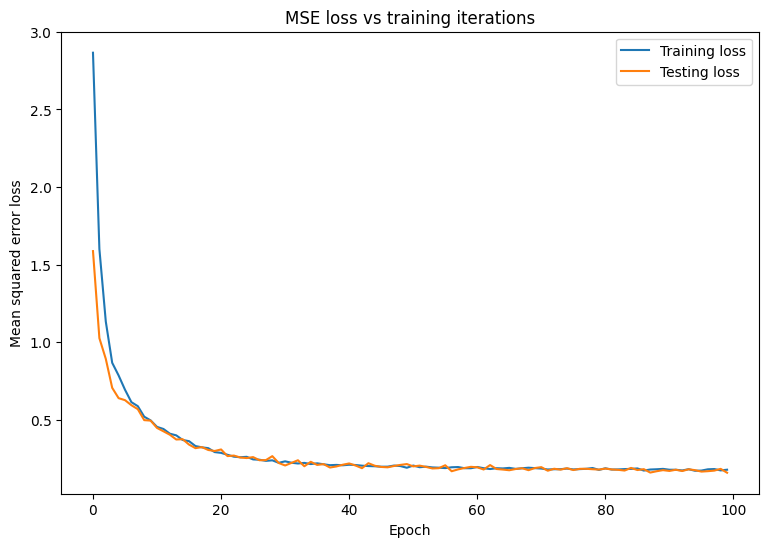

In [13]:
matplotlib.rcParams['figure.figsize'] = [9, 6]

plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Mean squared error loss")
plt.legend()
plt.title("MSE loss vs training iterations");

It seems like the model does a good job of fitting the training data while also generalizing well to the unseen test data.

## Save and load the model

Start by making an export module that takes in raw data and performs the following operations:
- Feature extraction 
- Normalization 
- Prediction
- Unnormalization

In [14]:
class ExportModule(tf.Module):
  def __init__(self, model, extract_features, norm_x, norm_y):
    # Initialize pre and postprocessing functions
    self.model = model
    self.extract_features = extract_features
    self.norm_x = norm_x
    self.norm_y = norm_y

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)]) 
  def __call__(self, x):
    # Run the ExportModule for new data points
    x = self.extract_features(x)
    x = self.norm_x.norm(x)
    y = self.model(x)
    y = self.norm_y.unnorm(y)
    return y 

In [15]:
lin_reg_export = ExportModule(model=lin_reg,
                              extract_features=onehot_origin,
                              norm_x=norm_x,
                              norm_y=norm_y)

If you want to save the model at its current state, use the `tf.saved_model.save` function. To load a saved model for making predictions, use the `tf.saved_model.load` function.

In [16]:
import tempfile
import os

models = tempfile.mkdtemp()
save_path = os.path.join(models, 'lin_reg_export')
tf.saved_model.save(lin_reg_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp82n361w_/lin_reg_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmp82n361w_/lin_reg_export/assets


In [17]:
lin_reg_loaded = tf.saved_model.load(save_path)
test_preds = lin_reg_loaded(x_test)
test_preds[:10].numpy()

array([28.097498, 26.193336, 33.564373, 27.719315, 31.787922, 24.014559,
       24.421043, 13.459579, 28.562454, 27.368692], dtype=float32)

## Conclusion

Congratulations! You have trained a regression model using the TensorFlow Core low-level APIs.

For more examples of using TensorFlow Core APIs, check out the following guides:
* [Logistic regression](./logistic_regression_core.ipynb) for binary classification
* [Multi-layer perceptrons](./mlp_core.ipynb) for hand-written digit recognition
